In [18]:
import pandas as pd
raw_data=pd.read_csv("comptage-velo-donnees-compteurs.csv",sep=";")

data=raw_data.loc[:,["id","sum_counts","date","coordinates"]]
data=data.rename(columns={"sum_counts":"counts"})

data=data.drop(data[data.coordinates.isnull()].index,axis=0)
#FURHTER EXPLORE: there are counters with isnull().sum()!=0 Always the same? Interpolate or equal 0?

data=data.astype({"id":int})

#Only care relative time (people always go to work at 8am, dont care about UTC)
split_date=data["date"].str.split("+",expand=True)
data["date"]=split_date[0]
data["UTC+"]=split_date[1]
data["date"]=pd.to_datetime(data['date'])#,utc=True)
# format='%Y-%m-%dT%H:%M:%S%z'

data["day"]=data['date'].dt.date
data["hour"]=data["date"].dt.hour #Since data.date.dt.minute.sum()=0, dont care about else

data[["lat","lon"]]=data["coordinates"].str.split(",",expand=True)
data["coordinates"]=data["coordinates"].str.split(",",expand=False)

<Axes: xlabel='date'>

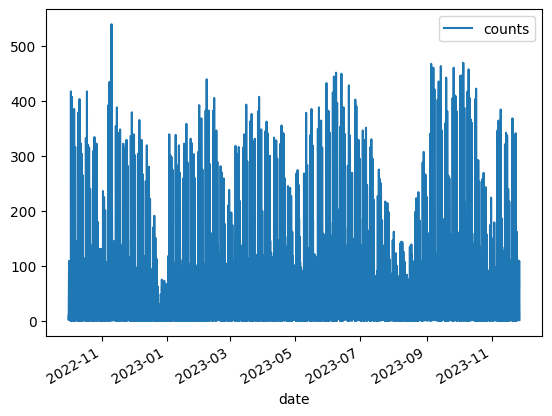

In [84]:
counts_test=data[data["id"]==data["id"][0]]
counts_test.plot(x="date",y="counts")

<Axes: xlabel='date'>

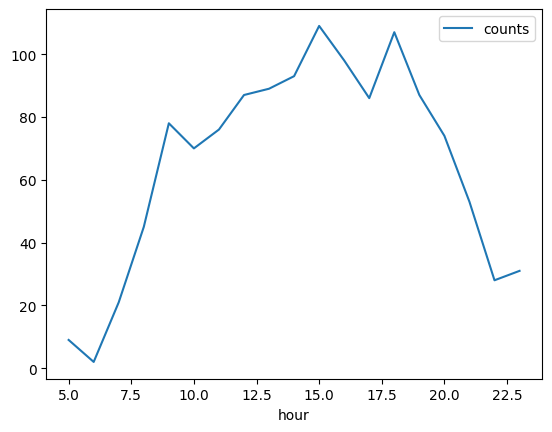

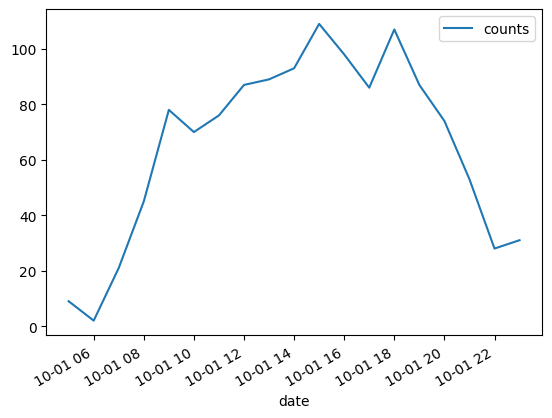

In [85]:
day_test=counts_test[counts_test["day"]==counts_test["day"][0]]
day_test.sort_values("hour").plot(x="hour",y="counts",)
day_test.plot(x="date",y="counts")

<Axes: xlabel='hour'>

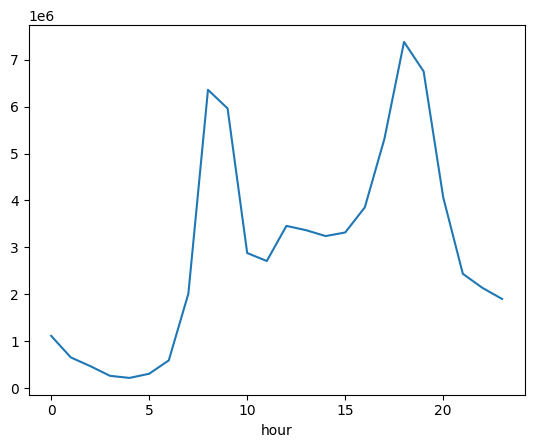

In [91]:
traffic_pattern=data.groupby("hour")["counts"].sum()
traffic_pattern.plot()

Text(0.5, 1.0, 'Traffic flow simulation')

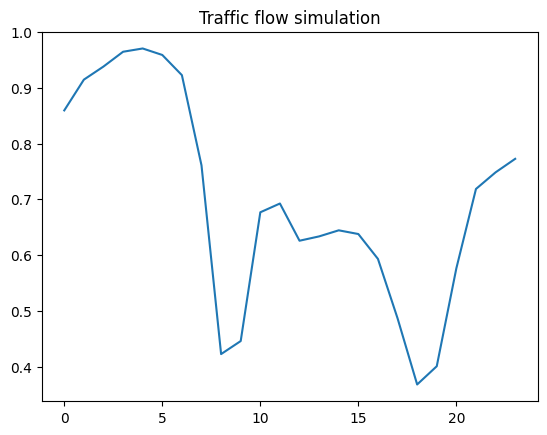

In [98]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.exp(-traffic_pattern/traffic_pattern.max()))
plt.title("Traffic flow simulation")